In [226]:
import pandas as pd
import numpy as np
# import seaborn as sns
from math import floor, sqrt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

ic = pd.read_excel("D:\DS\Mine\Corona\I22-02-22.xlsx", index_col=0, parse_dates=[0])
ic['total_vaccinations_f'] = ic['total_vaccinations'].interpolate(method='linear').fillna(0)
ic['stringency_index_f'] = ic['stringency_index'].fillna(method="ffill")
icf = ic.loc[ : , ['total_cases', 'new_cases', 'new_cases_smoothed',
                   'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_vaccinations_f', 'stringency_index_f']]
icf = icf.asfreq(None)
pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option('display.max_rows', 2000)
icf

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_vaccinations_f,stringency_index_f
date,,,,,,,,
2020-02-19,2,2,NaN,2,2,NaN,0.00,0.00
2020-02-20,5,3,NaN,2,0,NaN,0.00,2.78
2020-02-21,18,13,NaN,4,2,NaN,0.00,2.78
2020-02-22,28,10,NaN,5,1,NaN,0.00,11.11
2020-02-23,43,15,NaN,8,3,NaN,0.00,11.11
...,...,...,...,...,...,...,...,...
2022-02-17,6894110,17545,"23,357.43",134420,182,160.86,"138,620,249.00",62.04
2022-02-18,6913427,19317,"21,653.14",134607,187,167.14,"138,883,111.00",62.04
2022-02-19,6925485,12058,"20,718.86",134798,191,175.43,"139,147,658.00",62.04


In [276]:
start_date = '2022-01-15'
icc = icf.loc[start_date: , 'new_cases_smoothed'] 
# icc -= icc.iloc[0]

icd = icf.loc[start_date: , 'total_deaths']
icd -= icd.iloc[0]

# icc, icd

In [277]:
# icc.iloc[0] = icc.iloc[1] / 2
xtc = icc.values
xtd = icd.values
# icf.loc[start_date , 'new_cases_smoothed'] 
icc

date
2022-01-15    1,973.71
2022-01-16    2,089.71
2022-01-17    2,265.57
2022-01-18    2,507.29
2022-01-19    2,788.86
2022-01-20    3,112.29
2022-01-21    3,503.29
2022-01-22    3,800.71
2022-01-23    4,208.14
2022-01-24    4,855.00
2022-01-25    5,672.86
2022-01-26    6,785.86
2022-01-27    8,161.14
2022-01-28    9,801.29
2022-01-29   10,976.71
2022-01-30   13,384.14
2022-01-31   16,427.57
2022-02-01   20,097.86
2022-02-02   23,856.29
2022-02-03   27,157.71
2022-02-04   30,036.43
2022-02-05   31,664.86
2022-02-06   33,583.86
2022-02-07   35,130.14
2022-02-08   35,656.86
2022-02-09   35,789.00
2022-02-10   35,258.43
2022-02-11   34,449.71
2022-02-12   33,802.29
2022-02-13   32,428.43
2022-02-14   30,876.57
2022-02-15   28,916.14
2022-02-16   25,662.57
2022-02-17   23,357.43
2022-02-18   21,653.14
2022-02-19   20,718.86
2022-02-20   19,455.29
2022-02-21   18,048.71
Freq: D, Name: new_cases_smoothed, dtype: float64

1973.714
Infected people


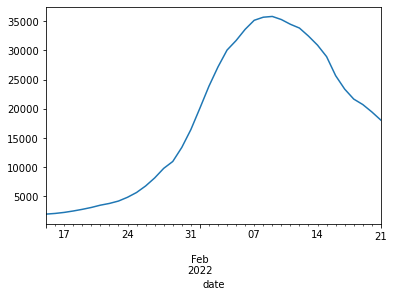

In [278]:
print(icc[0])
icc.plot()
print('Infected people')

Deaths


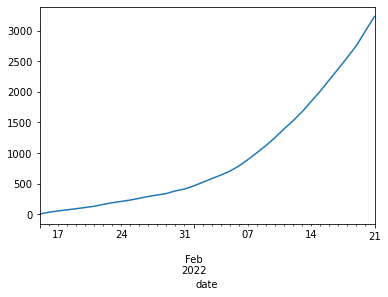

In [279]:
icd.plot()
print('Deaths')

In [280]:
# Birth rate (convert yearly to daily)
BR = 1.013 ** (1 / 365) - 1
print(BR, (1 + BR) ** 365)
# print(BR * N * 365)

3.538754466281269e-05 1.0129999999999786


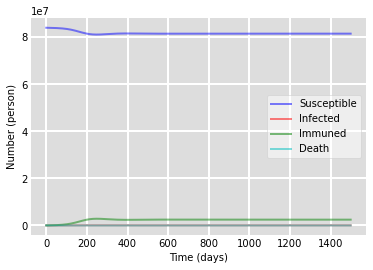

In [281]:
# First ref:
# https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

    # The SIR model differential equations.
def derivs(y, t, N, beta, gamma, nu, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N + delta * R  #+ BR * N 
    dIdt = beta * S * I / N - gamma * I - nu * I
    dRdt = gamma * I - delta * R
    dDdt = nu * I
#     print('>> Actuals', S, I, R, D)
#     print('d/d', dSdt, dIdt, dRdt, dDdt)
    return dSdt, dIdt, dRdt, dDdt

    # Main
    # Initial conditions vector
    # Total population, N.
N = 84 * 10 ** 6
    # Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = icc.iloc[0], 1 #6.5 * 10 ** 6
    # Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
BR = 1.013 ** (1 / 365)
D0 = 0 # Only for Omicron

    # Rates per day
    # beta: Contact rate, beta
beta = 0.9
    # gamma: Recovery/removing rate, gamma
gamma = 0.873
    # nu: Deaths occuring out of daily removed people
nu = 0.0001
    # delta: rate of loss of immunity in entire removed (immuned) people
delta = 0.02

    # A grid of time points (in days)
t = np.linspace(0, 1499, 1500)
y0 = S0, I0, R0, D0

    # Integrate the SIR equations over the time grid, t.
ret = odeint(derivs, y0, t, args=(N, beta, gamma, nu, delta))
S, I, R, D = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Immuned')
ax.plot(t, D, 'c', alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [282]:
print(t, len(t))

[0.000e+00 1.000e+00 2.000e+00 ... 1.497e+03 1.498e+03 1.499e+03] 1500


In [334]:
def plot(t, y, name = 'Item', col = 'r'):
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t, y, col, alpha=0.5, lw=2, label=name)
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number (person)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()
    return ax
#     ax.plot(t, S, 'b', alpha=0.5, lw=2, label=name)

In [284]:
import math
def maxI(x):
    return N - N * x[1] / x[0] * (1 + math.log(x[0] / (N * x[1]) * S0))

cons = ()#{'type': 'ineq', 'fun': lambda x: -(maxI(x) - 40000)})#, {'type': 'ineq', 'fun': lambda x: -(maxI(x) - 40000)})

pzero = [0.9, 0.873, 0.000001, 0.01, 100]
print(maxI(pzero))

40099.2692412287


In [285]:
days = list(range(len(xtc)))
print(days)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


In [539]:
from sklearn.metrics import mean_squared_error
def error_for_ID(x):
#     print(x)
    ebeta, egamma, enu, edelta, inf_ratio = x[0], x[1], x[2], x[3], x[4]
    res = odeint(derivs, y0, days, args=(N, ebeta, egamma, enu, edelta))
    S, I, R, D = res.T
    err = mean_squared_error(I, xtc) / x[4] + mean_squared_error(D[:], xtd[:])
    err += len(xtc)/20 *  mean_squared_error(I[-20:], xtc[-20:]) / x[4] + 5 * len(xtd)/4 * mean_squared_error(D[-4:], xtd[-4:])
    
#     print(err)
    return err 

In [540]:
from scipy.optimize import minimize

# param_bounds=([0, 0, 0, 0], [1, 1, 0.000001, 0.01])
param_bounds = ((0, 9), (0, None), (0, None), (0.03, 0.6), (10, 1000))
x = np.array([beta, gamma, nu, delta])

 
res = minimize(error_for_ID, x0=pzero, constraints=cons, bounds=param_bounds)
print(res)

      fun: 456628.9004856626
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 29368.68713391, -30110.17124773,  38021.31977886,  28988.71898165,
         -363.84415821])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1182
      nit: 98
     njev: 197
   status: 0
  success: True
        x: array([4.79876140e+00, 4.67972788e+00, 5.21955118e-03, 4.74161229e-02,
       1.00000000e+03])


In [541]:
# Optimized
ox = res.x
obeta, ogamma, onu, odelta = ox[0], ox[1], ox[2], ox[3]
print(ox)
maxI(ox)

[4.79876140e+00 4.67972788e+00 5.21955118e-03 4.74161229e-02
 1.00000000e+03]


27984.317369684577

In [542]:
ret = odeint(derivs, y0, days, args=(N, obeta, ogamma, onu, odelta))
S, I, R, D = ret.T
# print(I)
# print(D)

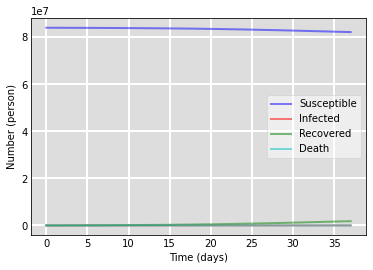

In [543]:
    # Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(days, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(days, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(days, D, 'c', alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (person)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

In [544]:
I

array([ 1973.714     ,  2210.77112578,  2474.86330023,  2768.77182458,
        3095.49202737,  3458.23107823,  3860.39977978,  4305.59664655,
        4797.58233888,  5340.24226699,  5937.5350243 ,  6593.4237456 ,
        7311.78843747,  8096.31604832,  8950.36660128,  9876.81377394,
       10877.8594424 , 11954.82347401, 13107.91193592, 14335.96954699,
       15636.2254894 , 17004.0452054 , 18432.70451457, 19913.20586174,
       21434.15918883, 22981.75118863, 24539.82585271, 26090.09564541,
       27612.49590676, 29085.68517235, 30487.68147845, 31796.6104822 ,
       32991.52701659, 34053.25955389, 34965.21906459, 35714.11167581,
       36290.49932685, 36689.16419363])

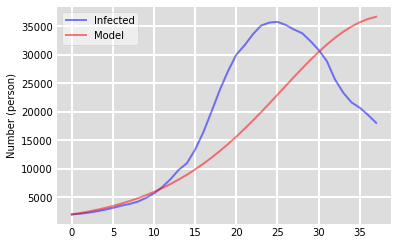

In [545]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, xtc, 'b', alpha=0.5, lw=2, label='Infected')
ax.plot(days, I, 'r', alpha=0.5, lw=2, label='Model')
# ax.plot(days, y_hat1, 'g', alpha=0.5, lw=2, label='Model1')
ax.set_ylabel('Number (person)')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

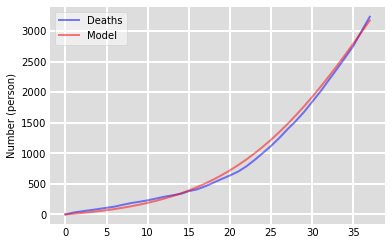

In [546]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(days, xtd, 'b', alpha=0.5, lw=2, label='Deaths')
ax.plot(days, D, 'r', alpha=0.5, lw=2, label='Model')
# ax.plot(days, y_hat1, 'g', alpha=0.5, lw=2, label='Model1')
ax.set_ylabel('Number (person)')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

200


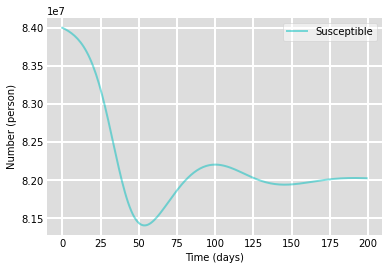

<AxesSubplot:xlabel='Time (days)', ylabel='Number (person)'>

In [547]:
t = np.linspace(0, 199, 200)
ret = odeint(derivs, y0, t, args=(N, obeta, ogamma, onu, odelta))
S, I, R, D = ret.T
population = S + I + R + D
print(len(S))
plot(t, S, 'Susceptible', 'c')

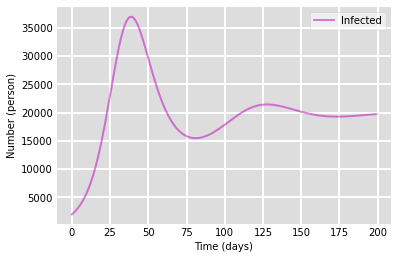

<AxesSubplot:xlabel='Time (days)', ylabel='Number (person)'>

In [548]:
plot(t, I, 'Infected', 'm')

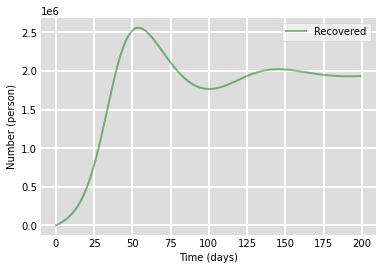

<AxesSubplot:xlabel='Time (days)', ylabel='Number (person)'>

In [549]:
plot(t, R, 'Recovered', 'g')

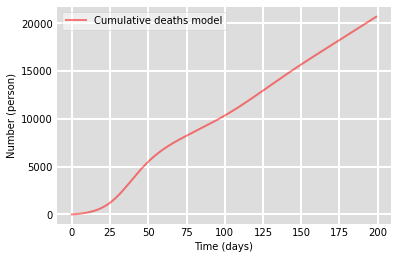

<AxesSubplot:xlabel='Time (days)', ylabel='Number (person)'>

In [550]:
plot(t, D, name='Cumulative deaths model')

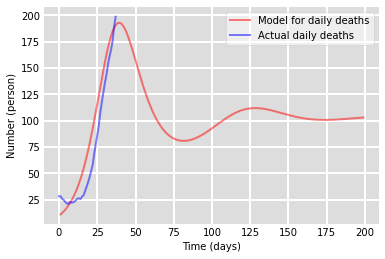

In [551]:
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(t[1:],  np.diff(D), 'r', alpha=0.5, lw=2, label='Model for daily deaths')
    ax.plot(days, icf.loc[start_date: , 'new_deaths_smoothed'].values, 'b', alpha=0.5, lw=2, label='Actual daily deaths')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Number (person)')
    # ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

In [552]:
print(ox)

[4.79876140e+00 4.67972788e+00 5.21955118e-03 4.74161229e-02
 1.00000000e+03]
